In [21]:
import math
import random

# determine whether qiskit can be used, or whether to default to
# MicroQiskit and the standard library
try:
    from qiskit import QuantumCircuit, quantum_info
    simple_python = False
except:
    print('Unable to import Qiskit, so MicroQiskit will be used instead')
    from microqiskit import QuantumCircuit, simulate
    simple_python = True

In [22]:
def generateTestImageHeights():
    size = 8 #square
    new_dictionary = {}
    for i in range(size):
        for j in range(size):
            new_dictionary[(i, j)] = random.uniform(0, 1)
            
    return new_dictionary

test_image_heights = generateTestImageHeights()
test_image_heights

{(0, 0): 0.7474775854205332,
 (0, 1): 0.9586968059978357,
 (0, 2): 0.055751473346010605,
 (0, 3): 0.06561167135694346,
 (0, 4): 0.3922683430859818,
 (0, 5): 0.8278299917031617,
 (0, 6): 0.16293958053508217,
 (0, 7): 0.468217737611788,
 (1, 0): 0.6065348276636948,
 (1, 1): 0.3319340452466535,
 (1, 2): 0.2527185628550469,
 (1, 3): 0.21302184750500974,
 (1, 4): 0.9694911584349653,
 (1, 5): 0.16675632460035816,
 (1, 6): 0.31773833632176285,
 (1, 7): 0.6595942171602999,
 (2, 0): 0.2871922402943051,
 (2, 1): 0.2510636947674705,
 (2, 2): 0.3166026954955652,
 (2, 3): 0.3594654392703337,
 (2, 4): 0.7924772993778562,
 (2, 5): 0.7938579846853958,
 (2, 6): 0.761325566151641,
 (2, 7): 0.7333420702417094,
 (3, 0): 0.9179207091595305,
 (3, 1): 0.2180194352994732,
 (3, 2): 0.19184505060676704,
 (3, 3): 0.8949490902654574,
 (3, 4): 0.7802395889883241,
 (3, 5): 0.7605795355610144,
 (3, 6): 0.855785933055532,
 (3, 7): 0.20070623561597345,
 (4, 0): 0.4317364499066668,
 (4, 1): 0.6690768846965708,
 (4, 2):

In [23]:
# this is overwritten by the PIL class if available
class Image():
    """
    A minimal reimplementation of the the PIL Image.Image class, to allow all
    image based tools to function even when only the standard library is
    available.
    
    To initialize an Image oject, use the `newimage` function.
    
    Attributes:
        mode (str): If L, pixel values are a single integer. If 'RGB', they
            are a tuple of three integers.
        size (tuple): Specifies width and height.
    """
    def __init__(self):
        self.mode = None
        self.size = None
        self._image_dict = None
    def getpixel(self,xy):
        """
        Returns pixel value at the given coordinate.
        """
        return self._image_dict[xy]
    def putpixel(self, xy, value):
        """
        Sets the pixel value at the given coordinate.
        """
        self._image_dict[xy] = value
    def todict(self):
        """
        Returns dictionary of pixel values with coordinates as keys.
        Not present in PIL version.
        """
        return self._image_dict
    def show(self):
        """
        If the PIL version of this class is used, this function creates a PNG
        image and displays it. This version instead simply prints all
        coordinates and pixel values.
        """
        for x in range(self.size[0]):
            for y in range(self.size[1]):
                print('('+str(x)+','+str(y)+')'+': '+str(self._image_dict[x,y]))
    def resize(self, new_size, method):
        print("This functionality has not been implemented.")

# this is overwritten by the PIL function if available               
def newimage(mode, size):
    """
    A minimal reimplementation of the the PIL Image.new function.
    Creates an Image object for the given mode and size.
    """
    img = Image()
    img.mode = mode
    img.size = size
    if mode=='L':
        blank = 0
    elif mode=='RGB':
        blank = (0,0,0)
    img._image_dict = {(x,y):blank\
                for x in range(size[0])\
                for y in range(size[1])}
    return img

# if external libraries can be used, import the ones we need
if not simple_python:
    import numpy as np
    from scipy.linalg import fractional_matrix_power
    from PIL.Image import new as newimage, Image


def _kron(vec0,vec1):
    """
    Calculates the tensor product of two vectors.
    """
    new_vec = []
    for amp0 in vec0:
        for amp1 in vec1:
            new_vec.append(amp0*amp1)
    return new_vec


def _get_size(height):
    """
    Determines the size of the grid for the given height map.
    """
    Lx = 0
    Ly = 0
    for (x,y) in height:
        Lx = max(x+1,Lx)
        Ly = max(y+1,Ly)
    return Lx,Ly


def circuit2probs(qc):
    """
    Runs the given circuit, and returns the resulting probabilities.
    """
    if simple_python:
        probs = simulate(qc,get='probabilities_dict')
    else:
        # separate circuit and initialization
        new_qc = qc.copy()
        new_qc.data = []
        initial_ket = [1]
        for gate in qc.data:
            if gate[0].name=='initialize':
                initial_ket = _kron(initial_ket,gate[0].params)
            else:
                new_qc.data.append(gate)
        # if there was no initialization, use the standard state        
        if len(initial_ket)==1:
            initial_ket = [0]*2**qc.num_qubits
            initial_ket[0] = 1       
        # then run it
        ket = quantum_info.Statevector(initial_ket)
        ket = ket.evolve(new_qc)
        probs = ket.probabilities_dict()
    
    return probs


def _image2heights(image):
    """
    Converts a grayscale image into a list of heights
    """
    
    Lx,Ly = image.size
    heights = {}
    for x in range(Lx):
        for y in range(Ly):
            heights[x,y] = image.getpixel((x,y))

    return heights


def _height2image(height):
    """
    Constructs an image from a dictionary
    """
    Lx,Ly = _get_size(height)
    h_max = max(height.values())

    image = newimage('L', (Lx, Ly))
    for x in range(Lx):
        for y in range(Ly):
            if (x,y) in height:
                h = float(height[x,y])/h_max
            else:
                h = 0
            image.putpixel((x,y), int(255*h) )

    return image



def make_line ( length ):
    """
    Creates a list of bit strings of at least the given length, such
    that the bit strings are all unique and consecutive strings
    differ on only one bit.
    
    Args:
        length (int): Required length of output list.
    
    Returns:
        line (list): List of 2^n n-bit strings for n=⌊log_2(length)⌋
    """
    
    # number of bits required
    n = int(math.ceil(math.log(length)/math.log(2)))
    
    # iteratively build list
    line = ['0','1']
    for j in range(n-1):
        # first append a reverse-ordered version of the current list
        line = line + line[::-1]
        # then add a '0' onto the end of all bit strings in the first half
        for j in range(int(float(len(line))/2)):
            line[j] += '0'
        # and a '1' for the second half
        for j in range(int(float(len(line))/2),int(len(line))):
            line[j] += '1'
            
    return line


def normalize(ket):
    """
    Normalizes the given statevector.
    
    Args:
        ket (list or array_like)
    
    Returns:
        ket (list or array_like)
    """
    N = 0
    for amp in ket:
        N += amp*amp.conjugate()
    for j,amp in enumerate(ket):
        ket[j] = float(amp)/math.sqrt(N)
    return ket


def make_grid(Lx,Ly=None):
    """
    Creates a dictionary that provides bit strings corresponding to
    points within an Lx by Ly grid.
    
    Args:
        Lx (int): Width of the lattice (also the height if no Ly is
            supplied).
        Ly (int): Height of the lattice if not Lx.
    
    Returns:
        grid (dict): Dictionary whose values are points on an
            Lx by Ly grid. The corresponding keys are unique bit
            strings such that neighbouring strings differ on only
            one bit.
        n (int): Length of the bit strings
        
    """
    # set Ly if not supplied
    if not Ly:
        Ly = Lx
    
    # make the lines
    line_x = make_line( Lx )
    line_y = make_line( Ly )
    
    # make the grid
    grid = {}
    for x in range(Lx):
        for y in range(Ly):
            grid[ line_x[x]+line_y[y] ] = (x,y)
            
    # determine length of the bit strings
    n = len(line_x[0]+line_y[0])
            
    return grid, n


def height2circuit(height, log=False, eps=1e-2):
    """
    Converts a dictionary of heights (or brightnesses) on a grid into
    a quantum circuit.
    
    Args:
        height (dict): A dictionary in which keys are coordinates
            for points on a grid, and the values are positive numbers of
            any type.
        log (bool): If given, a logarithmic encoding is used.
            
    Returns:
        qc (QuantumCircuit): A quantum circuit which encodes the
            given height dictionary.
    """
    # get bit strings for the grid
    Lx,Ly = _get_size(height)
    grid, n = make_grid(Lx,Ly)
    
    # create required state vector
    state = [0]*(2**n)
    if log:
        # normalize heights
        max_h = max(height.values())
        height = {pos:float(height[pos])/max_h for pos in height}
        # find minimum (not too small) normalized height
        min_h = min([height[pos] for pos in height if height[pos] > eps])
        # this minimum value defines the base
        base = 1.0/min_h
    for bitstring in grid:
        (x,y) = grid[bitstring]
        if (x,y) in height:
            h = height[x,y]

            if log:
                state[ int(bitstring,2) ] = math.sqrt(base**(float(h)/min_h))
            else:
                state[ int(bitstring,2) ] = math.sqrt( h )
    state = normalize(state)
        
    # define and initialize quantum circuit            
    #qc = QuantumCircuit(n,n)
    qc = QuantumCircuit(n)
    if simple_python:
        # microqiskit style
        qc.initialize(state)
    else:
        qc.initialize(state,range(n))
    qc.name = '('+str(Lx)+','+str(Ly)+')'

    return qc


def probs2height(probs, size=None, log=False):
    """
    Extracts a dictionary of heights (or brightnesses) on a grid from
    a set of probabilities for the output of a quantum circuit into
    which the height map has been encoded.
    
    Args:
        probs (dict): A dictionary with results from running the circuit.
            With bit strings as keys and either probabilities or counts as
            values.
        size (tuple): Size of the height map to be created. If not given,
            the size is deduced from the number of qubits (assuming a
            square image).
        log (bool): If given, a logarithmic decoding is used.
            
    Returns:
        height (dict): A dictionary in which keys are coordinates
            for points on a grid, and the values are floats in the
            range 0 to 1.
    """
    
    # get grid info
    if size:
        (Lx,Ly) = size
    else:
        Lx = int(2**(len(list(probs.keys())[0])/2))
        Ly = Lx
    grid,_ = make_grid(Lx,Ly)
    
    # set height to probs value, rescaled such that the maximum is 1
    max_h = max( probs.values() )   
    height = {(x,y):0.0 for x in range(Lx) for y in range(Ly)}
    
    # We remove the fisrt element of the bitstring
    
    probs_copy = dict(probs)
    
    for bitstring in probs_copy:
        new_bitstring = bitstring[1:]
        probs[new_bitstring] = probs.pop(bitstring)
        
    # ----------------------------------------------
    
    for bitstring in probs:
        if bitstring in grid:
            height[grid[bitstring]] = float(probs[bitstring])/max_h
  
    # take logs if required
    if log:
        min_h = min([height[pos] for pos in height if height[pos] !=0])
        alt_min_h = min([height[pos] for pos in height])
        base = 1/min_h
        for pos in height:
            if height[pos]>0:
                height[pos] = max(math.log(height[pos]/min_h)/math.log(base),0)
            else:
                height[pos] = 0.0
                
    return height

    
def circuit2height(qc, log=False):
    """
    Extracts a dictionary of heights (or brightnesses) on a grid from
    the quantum circuit into which it has been encoded.
    
    Args:
        qc (QuantumCircuit): A quantum circuit which encodes a height
            dictionary. The name attribute should hold the size of
            the image to be created (as a tuple cast to a string).
        log (bool): If given, a logarithmic decoding is used.
            
    Returns:
        height (dict): A dictionary in which keys are coordinates
            for points on a grid, and the values are floats in the
            range 0 to 1.
    """
    
    probs = circuit2probs(qc)

    try:
        # get size from circuit
        size = eval(qc.name)
    except:
        # if not in circuit name, infer it from qubit number
        L = int(2**(qc.num_qubits/2))
        size = (L,L)
        
    return probs2height(probs, size=size, log=log)


def combine_circuits(qc0,qc1):
    """
    Combines a pair of initialization circuits in parallel
    Creates a single register circuit with the combined number of qubits,
    initialized with the tensor product state.
    """

    warning = "Combined circuits should contain only initialization."

    # create a circuit with the combined number of qubits
    num_qubits = qc0.num_qubits + qc1.num_qubits
    combined_qc = QuantumCircuit(num_qubits)

    # extract statevectors for any initialization commands
    kets = [None,None]
    for j,qc in enumerate([qc0, qc1]):
        for gate in qc.data:
            if simple_python:
                assert gate[0]=='init', warning
                kets[j] = gate[1]
            else:
                assert gate[0].name=='initialize', warning
                kets[j] = gate[0].params

    # combine into a statevector for all the qubits
    ket = None
    if kets[0] and kets[1]:
        ket = _kron(kets[0], kets[1])
    elif kets[0]:
        ket = _kron(kets[0], [1]+[0]*(2**qc1.num_qubits-1))
    elif kets[1]:
        ket = _kron([1]+[0]*(2**qc0.num_qubits-1),kets[1])

    # use this to initialize
    if ket:
        if simple_python:
            combined_qc.initialize(ket)
        else:
            combined_qc.initialize(ket,range(num_qubits))
    
    # prevent circuit name from being used for size determination
    combined_qc.name = 'None'
            
    return combined_qc


def partialswap(combined_qc, fraction):
    """
    Apply a partial swap to a given combined circuit (made up of two equal
    sized circuits combined in parallel) by the given fraction.
    """
    num_qubits = int(combined_qc.num_qubits/2)
    
    if not simple_python:
        U = np.array([
        [1, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 1]
        ])
        U = fractional_matrix_power(U,fraction)
    for q in range(num_qubits):
        q0 = q
        q1 = num_qubits + q
        if not simple_python:
            combined_qc.unitary(U, [q0,q1],\
                                 label='partial_swap')
        else:
            combined_qc.cx(q1,q0)
            combined_qc.crx(math.pi*fraction,q0,q1)
            combined_qc.cx(q1,q0)  

            
def probs2marginals(combined_qc, probs):
    """
    Given a probability distribution corresponding to a given combined
    circuit (made up of two equal sized circuits combined in parallel),
    this function returns the two marginals for each subcircuit.
    """
    num_qubits = int(combined_qc.num_qubits/2)
    
    marginals = [{},{}]
    for string in probs:
        substrings = [string[0:num_qubits], string[num_qubits::]]
        for j,substring in enumerate(substrings):
            if substring in marginals[j]:
                marginals[j][substring] += probs[string]
            else:
                marginals[j][substring] = probs[string]
    
    return marginals


def swap_heights(height0, height1, fraction, log=False, ):
    """
    Given a pair of height maps for the same sized grid, a set of partial
    swaps is applied between corresponding qubits in each circuit.
    
    Args:
        height0, height1 (dict): Dictionaries in which keys are coordinates
            for points on a grid, and the values are floats in the range 0
            to 1.
        fraction (float): Fraction of swap gates to apply.
        log (bool): If given, a logarithmic decoding is used.
            
    Returns:
        new_height0, new_height1 (dict): As with the height inputs.
    """

    assert _get_size(height0)==_get_size(height1), \
    "Objects to be swapped are not the same size"   
    
    # set up the circuit to be run
    circuits = [height2circuit(height) for height in [height0,height1]]
    combined_qc = combine_circuits(circuits[0], circuits[1])
    partialswap(combined_qc, fraction)
    
    # run it an get the marginals for each original qubit register
    p = circuit2probs(combined_qc)           
    marginals = probs2marginals(combined_qc, p)     
    
    # convert the marginals to heights
    new_heights = []
    for j,marginal in enumerate(marginals):
        new_heights.append( probs2height(marginal,size=eval(circuits[j].name),log=log) )
        
    return new_heights[0], new_heights[1]


def height2image(height):
    """
    Converts a dictionary of heights (or brightnesses) on a grid to
    an image.
    Args:
        height (dict): A dictionary in which keys are coordinates
                for points on a grid, and the values are positive
                numbers of any type.
    Returns:
        image (Image): Monochrome image for which the given height
            dictionary determines the brightness of each pixel. The
            maximum value in the height dictionary is always white.
    """
    Lx,Ly = _get_size(height)
    h_max = max(height.values())
    print(height)

    image = newimage('L',(Lx,Ly))
    for x in range(Lx):
        for y in range(Ly):
            if (x,y) in height:
                h = float(height[x,y])/h_max
            else:
                h = 0
            image.putpixel((x,y), int(255*h) )

    return image


def image2circuit(image, log=False):
    """
    Converts an image to a circuit.
    Args:
        image (Image): A grayscale encoded image.
        log (bool): If given, a logarithmic encoding is used.
    Returns:
        circuits (list): A list of quantum circuits encoding the image.
    """

    height = _image2heights(image)

    return height2circuit(height, log=log)



def circuit2image(circuit, log=False):
    """
    Extracts an image from list of circuits encoding the RGB channels.
    Args:
        circuit (QCircuit): A quantum circuit encoding the image.
        log (bool): If given, a logarithmic decoding is used.
    Returns:
        image (Image): A grayscale encoded image.
    """
    
    height = circuit2height(circuit, log=log)

    return _height2image(height)



def row_swap_images(image0, image1, fraction, log=False):
    """
    A variant of `swap_images` in which the swap process is done on each line
    of the images individually, rather than with the images as a whole. This
    makes it much faster.
    
    Args:
        image0, image1 (Image): RGB encoded images.
        fraction (float): Fraction of swap gates to apply.
        log (bool): If given, a logarithmic decoding is used.
            
    Returns:
        new_image0, new_image1 (Image): RGB encoded images.
    """
    images = [image0, image1]

    Lx,Ly = images[0].size

    # create separate images for each row
    rows = [[],[]]
    for j in range(2):
        for y in range(Ly):   
            rows[j].append(newimage('RGB',(Lx,1)))
            for x in range(Lx):
                rows[j][y].putpixel((x,0),images[j].getpixel((x,y)))


    # do the swap on the row images
    for y in range(Ly):
        rows[0][y], rows[1][y] = swap_images(rows[0][y], rows[1][y], fraction, log=log)

    # reconstruct the full images
    new_images = [newimage('RGB',(Lx,Ly)) for _ in range(2)]
    for j in range(2):
        for y in range(Ly):
            for x in range(Lx):
                new_images[j].putpixel((x,y),rows[j][y].getpixel((x,0)))

    return new_images[0], new_images[1]


def blur_height(height, xi, axis='x', circuit=None, log=False):
    """
    Applies a predetermined blur effect designed for a smooth blur.
    
    Args:
        height (dict): A dictionary in which keys are coordinates
            for points on a grid, and the values are positive numbers of
            any type.
        xi (float): Fraction of pi rotation to apply on the qubit for
            which the largest rotation is aplied
        axis (string): `rx` rotations are used when this is `'x'`, and
            `ry` rotations are used otherwise.
        circuit (QuantumCircuit): Rotations are applied to the given circuit
            if supplied. Otherwise one is made from `height`.
        log (bool): If True, a logarithmic encoding is used.
            
    Returns:
        circuit (QuantumCircuit): Circuit on which the blur effect has been
            added.
    """
    
    # get size and bit strings for the grid
    Lx,Ly = _get_size(height)
    grid, n = make_grid(Lx,Ly)
    # invert grid dict to have coords as keys
    coord_grid = {grid[string]:string for string in grid}
    
    rates = [0]*n
    for x in range(Lx):
        for y in range(Ly):
            # for this point, go through all neighbours
            # and find all bits on which address differs
            string  = coord_grid[x,y]
            axes = []
            for (dx,dy) in [(0,1),(0,-1),(1,0),(-1,0)]:
                if (x+dx,y+dy) in coord_grid:
                    nstring  = coord_grid[x+dx,y+dy]
                    for j,b in enumerate(nstring):
                        if b!=string[j]:
                            axes.append(n-j-1)
            # add the height at this point to the rates for each of these
            for j in axes:
                if (x,y) in height:
                    rates[j] += height[x,y]

    # normalize the rates
    max_rate = max(rates)
    for j in range(n):
        rates[j] /= max_rate
        
    # make the circuit the rotation
    qc_rot = QuantumCircuit(n)
    for j in range(n):
        theta = np.pi*rates[j]*np.pi*xi
        if axis=='x':
            qc_rot.rx(theta,j)
        else:
            qc_rot.ry(theta,j)
            
    # add to initial circuit
    if circuit:
        circuit = circuit + qc_rot
    else:
        circuit = height2circuit(height,log=log) + qc_rot
    circuit.name = '('+str(Lx)+','+str(Ly)+')'
        
    return circuit


def blur_image(image, xi, circuit=None, axis='x',log=False):
    """
    Applies a predetermined blur effect designed for a smooth blur.
    
    Args:
        image (Image): A grayscale encoded image.
        xi (float): Fraction of pi rotation to apply on the qubit for
            which the largest rotation is aplied
        axis (string): `rx` rotations are used when this is `'x'`, and
            `ry` rotations are used otherwise.
        circuits (list): Rotations are applied to the given circuits
            if supplied. Otherwise they are made from `image`.
        log (bool): If True, a logarithmic encoding is used.
            
    Returns:
        circuits (list): Circuits on which the blur effect has been
    """       

    heights = _image2heights(image)
    
    circuit = blur_height(heights, xi, axis=axis, circuit=circuit, log=log)

    return circuit



def dotdot(L,diamond=0,delta=0,depth=0):
    """
    Creates a circuit for a heightmap depicting the letteer 'I'.
    The circuit is designed to be low-depth and compatible with near-term devices.
    
    Args:
        L (int): Linear size of the image. Must be at least 32.
        diamond (float): Degree to which filling is done with a diamond effect (maximum at 1).
        delta (float): Strength of random variations to all rotations made (no randomness when 0).
        depth (int): Depth of a final random circuit using rotations, using rotations of strength
            delta and entangling gates.
            
    Returns:
        qc (QuantumCircuit): Quantum circuit encoding the height map
        line (list): A list of qubits, ordered such that all entangling gates are between neighbours.
    """
    
    def dt():
        if delta!=0:
            return delta*(0.5-random.random())*math.pi
        else:
            return 0
    
    # make sure L is a compatible value (a power of 2 and >= 32)
    assert L>=32, 'Size must be at least 32x32 pixels.'
    L = int(2**math.ceil(math.log(L)/math.log(2)))

    # qubits per register for I shape
    ni = 5

    # qubits per register for fill
    nf = int(math.log(L/2**ni)/math.log(2))

    # total qubits per register
    nr = ni + nf
    # and total
    n = 2*nr

    # entangling gates on the following pairs are required
    pair_extend = (1,nr+2)
    pairs_fill = [(ni+j,ni+nr+j) for j in range(nf)]

    # we assume qubits are on a line such that these pairs are neigbours
    line = list(pair_extend)
    for pair in pairs_fill:
        line += list(pair)
    for j in range(n):
        if j not in line:
            line.append(j)

    # two sets of disjoint pairs cover this line
    r1 = [(line[j-1],line[j]) for j in range(1,n,2)]
    r2 = [(line[j-1],line[j]) for j in range(2,n,2)]

    qc = QuantumCircuit(n)

    # fill
    fill_qubits = []
    for c,t in pairs_fill:
        qc.ry(math.pi/2+dt(),c)
        # for full fill, use theta=pi/2 here
        theta = (1-diamond)*math.pi/2
        qc.rx(theta,t)
        # otherwise, this cx gives a diamond effect
        if diamond!=0:
            qc.cx(c,t)

    # horizontal lines
    qc.rx(math.pi+dt(),ni-1)
    for j in [0,2,3]:
        qc.rx(math.pi/2+dt(),j)
    qc.rx(0.39*math.pi+dt(),1)

    # central bar
    qc.rx(math.pi+dt(),nr+1)
    qc.ry(math.pi/2+dt(),nr+4)
    qc.ry(math.pi/2+dt(),nr)
    qc.ry(math.pi/2+dt(),nr+3)

    # extend at top
    qc.rx(math.pi+dt(),1)
    if simple_python:
        qc.crx(math.pi/2,1,nr+2)
    else:
        qc.ch(1,nr+2)
    qc.x(1)

    # cover with cz gates to entangle everything
    for c,t in r1+r2:
        qc.cz(c,t)
        
    if delta!=0:
        for _ in range(depth):
            for j in range(n):
                qc.rx(dt(),j)
            for c,t in r1+r2:
                if simple_python:
                    qc.h(t)
                    qc.cx(c,t)
                    qc.h(t)
                else:
                    qc.cz(c,t)

    return qc, line

     »
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
q_4: »
     »
q_5: »
     »
«     ┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
«q_0: ┤0                                                                                                                                                                                                                                                                                                                                                                           

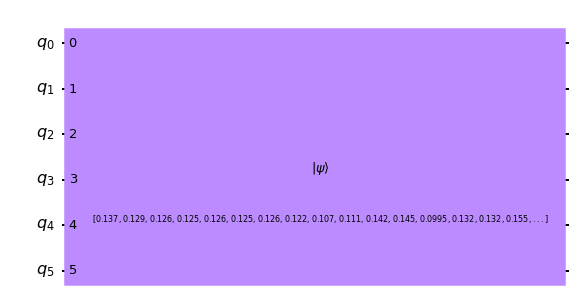

In [24]:

import PIL

with PIL.Image.open("woman8.png") as im:
    circ = image2circuit(im.getdata())
    figura = circ.draw(output = 'mpl')
    print(circ)
        
figura

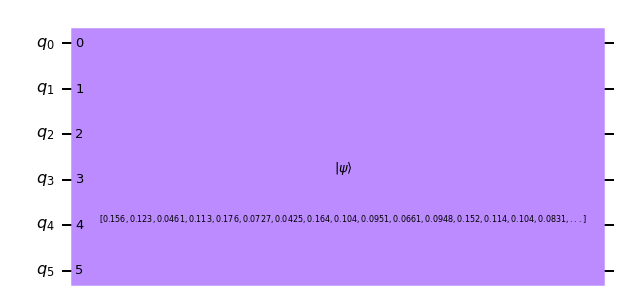

In [25]:
height2circuit(test_image_heights).draw(output = 'mpl')

In [26]:
from qiskit_ibm_provider import IBMProvider

provider = IBMProvider(token = 'ee712578df2a7f42e88af625ebfb80eee6267221d8d36da70c6cf1bd4cc45591054561622207e7b57713592c212ee22bf729a80d7d6ba09b35fbbea7cc015925')

hub = "ibm-q-community"
group = "digiq-icfo-hack"
project = "main"

backend_name = "ibmq_jakarta" # 7 qubits
#backend_name = "ibmq_guadalupe	" # 16 qubits

backend = provider.get_backend(backend_name, instance=f"{hub}/{group}/{project}")

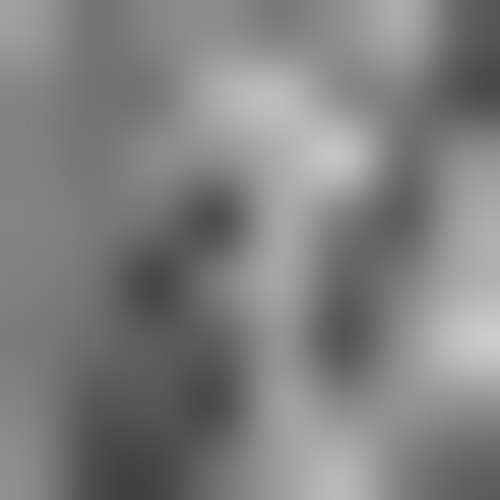

In [27]:
from qiskit import transpile
import PIL

with PIL.Image.open("woman8.png") as im:
    image_data = im.getdata()
    original_image = im
    
original_image.resize((500,500))

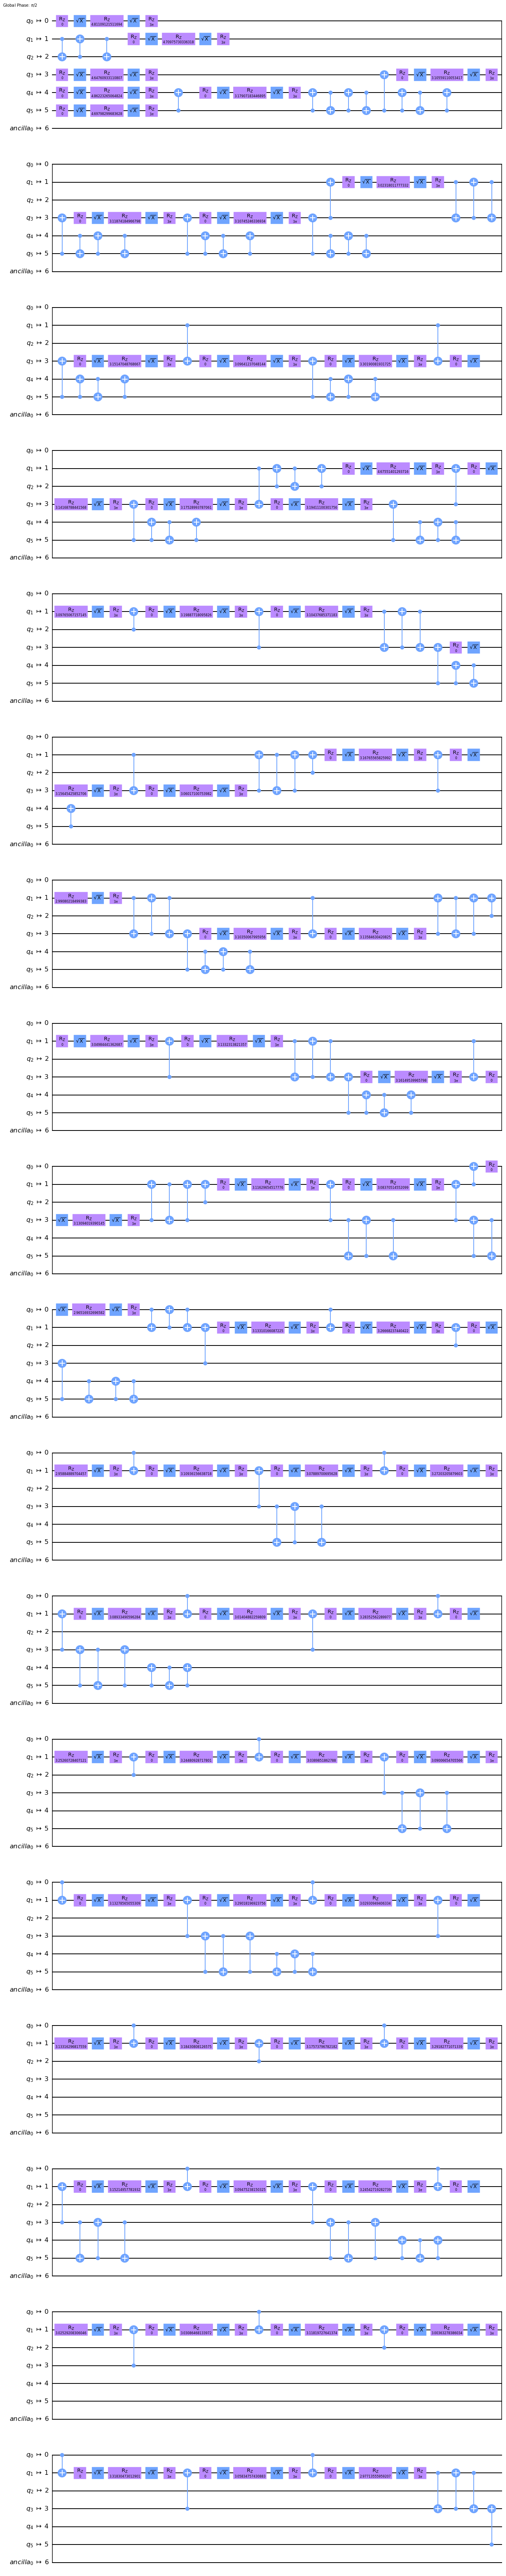

In [28]:
from qiskit import transpile

your_circuit = height2circuit(test_image_heights)

initial_layout=[0,1,2,3,4,5]

qc_transpiled = transpile(your_circuit, backend, initial_layout=initial_layout)

qc_transpiled.draw(output = 'mpl')

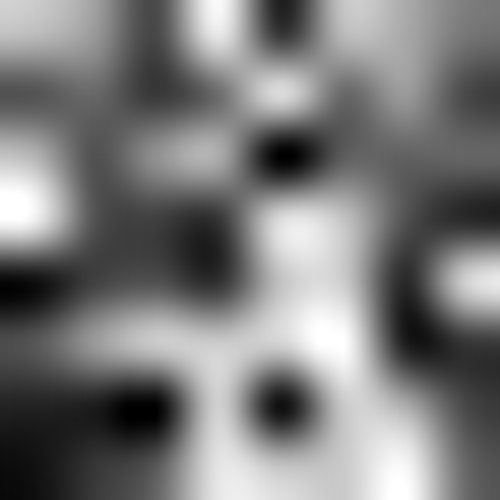

In [29]:
test_image_heights
image = circuit2image(qc_transpiled)
#height = circuit2height(qc_transpiled)
new_image = image.resize((500, 500))
new_image

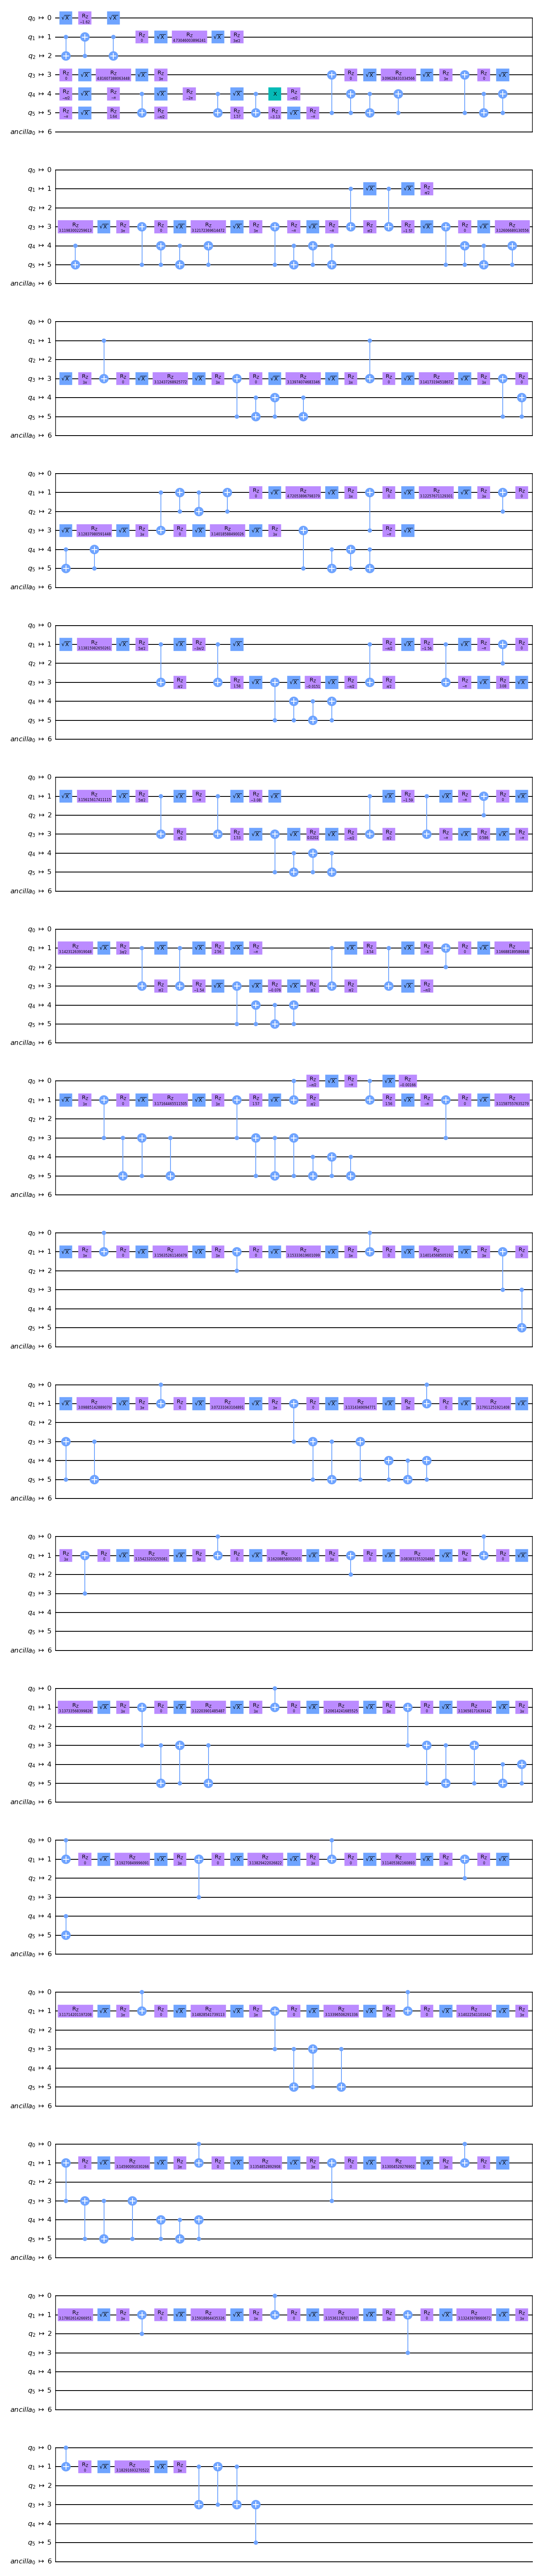

In [30]:
from qiskit import transpile
import PIL

with PIL.Image.open("woman8.png") as im:
    image_data = im.getdata()
    original_image = im

your_circuit = image2circuit(image_data)

initial_layout=[0,1,2,3,4,5]

qc_transpiled = transpile(your_circuit.decompose(), backend, initial_layout=initial_layout, optimization_level=3)

qc_transpiled.draw(output = 'mpl')

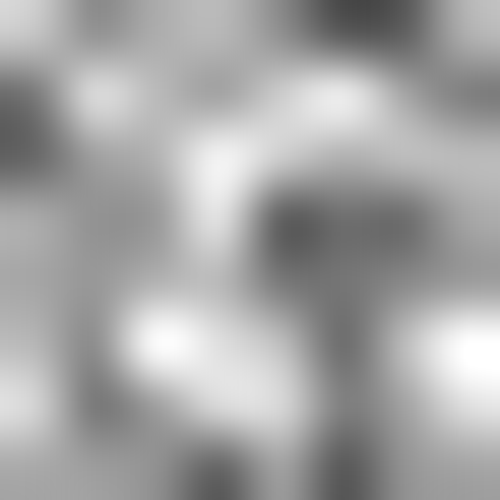

In [31]:
new_image = circuit2image(qc_transpiled)
new_image.resize((500,500))

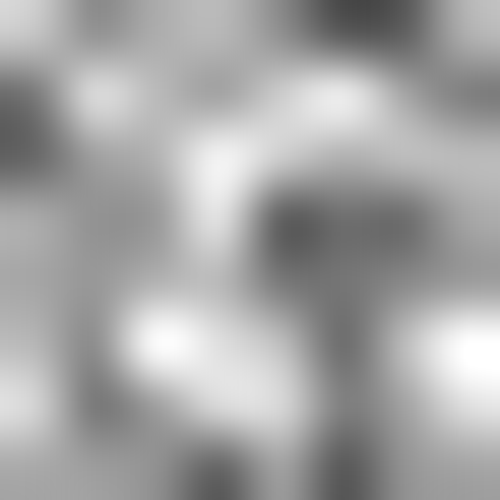

In [35]:
test_image_heights
image = circuit2image(qc_transpiled)
#height = circuit2height(qc_transpiled)
new_image = image.resize((500, 500))
new_image

In [38]:
#Here is the script for adding error mitigation methods using resilience levels, yet to be modified

from qiskit import execute, Aer
from qiskit_ibm_runtime import Options, Estimator, Session, QiskitRuntimeService, Sampler
from qiskit import ClassicalRegister 

service = QiskitRuntimeService()

cr = ClassicalRegister(6)

options = Options(simulator={
    "noise_model": None,
    "seed_simulator": seed,
}, resilience_level=1)

qc_transpiled.add_register(cr)

#options.optimization_level = 3

#with Session(service=service, backend=backend) as session:
#estimator = Estimator(session=session, options=options)

sampler = Sampler(session=backend, options=options)
job_dd = sampler.run(circuits=qc_transpiled)
print("job id:", job_dd.job_id)
print(job_dd.result())

ModuleNotFoundError: No module named 'qiskit_ibm_runtime'